In [ ]:
# Cleaning-only notebook
import pandas as pd
import numpy as np

# Optional: silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load and clean strictly from 'startup data.csv'
from pathlib import Path

raw_path = Path('startup data.csv')
if not raw_path.exists():
    raise FileNotFoundError("Expected 'startup data.csv' in project root.")

# Read raw
raw = pd.read_csv(raw_path, low_memory=False)
print(f"Raw shape: {raw.shape}")

# Normalize column names
raw.columns = [c.strip() for c in raw.columns]

# Drop duplicate/irrelevant columns
to_drop = [c for c in raw.columns if c.startswith('Unnamed')]
if 'state_code.1' in raw.columns:
    to_drop.append('state_code.1')
# Some IDs/strings not useful for modeling; we'll keep them for EDA but drop from features later
# Keep them in the dataframe; feature selection will exclude them

# Remove exact duplicate columns by name
raw = raw.loc[:, ~raw.columns.duplicated(keep='first')]
if to_drop:
    raw.drop(columns=[c for c in to_drop if c in raw.columns], inplace=True)

# Create binary target from status
if 'status' not in raw.columns:
    raise ValueError("Column 'status' not found in startup data.csv")
status_map = {'acquired': 1, 'operating': 0, 'closed': 0}
raw['target'] = raw['status'].map(lambda s: status_map.get(str(s).strip().lower(), 0)).astype(int)

# Coerce numeric columns
numeric_like = []
for c in raw.columns:
    if c == 'target':
        continue
    # Heuristic: try numeric coercion for columns that look numeric
    coerced = pd.to_numeric(raw[c], errors='coerce')
    # If coercion yields at least some non-NaNs and original wasn't object with many categories, accept
    if coerced.notna().sum() > 0 and (raw[c].dtype != object or raw[c].nunique(dropna=True) > 50):
        raw[c] = coerced
        numeric_like.append(c)

# Standardize boolean indicator columns (is_*, has_*) to int 0/1
for c in [c for c in raw.columns if c.startswith('is_') or c.startswith('has_')]:
    raw[c] = pd.to_numeric(raw[c], errors='coerce').fillna(0).astype(int)

# Simple numeric imputation with median
for c in [c for c in raw.columns if c not in ['status', 'target'] and pd.api.types.is_numeric_dtype(raw[c])]:
    if raw[c].isna().any():
        raw[c] = raw[c].fillna(raw[c].median())

# Drop rows with missing target
before = len(raw)
raw = raw.dropna(subset=['target'])
after = len(raw)
print(f"Dropped {before-after} rows with missing target")

# Expose cleaned as `data`
data = raw.copy()
print(f"Cleaned shape: {data.shape}")

data.head(20)
data


Raw shape: (923, 49)
Dropped 0 rows with missing target
Cleaned shape: (923, 47)


,state_code,latitude,longitude,zip_code,id,city,name,labels,founded_at,closed_at,...,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status,target
0,CA,42.358880,-71.056820,92101.0,c:6669,San Diego,Bandsintown,1,1/1/2007,NaN,...,0,1,0,0,0,0,1.0000,0,acquired,1
1,CA,37.238916,-121.973718,95032.0,c:16283,Los Gatos,TriCipher,1,1/1/2000,NaN,...,1,0,0,1,1,1,4.7500,1,acquired,1
2,CA,32.901049,-117.192656,92121.0,c:65620,San Diego,Plixi,1,3/18/2009,NaN,...,0,0,1,0,0,0,4.0000,1,acquired,1
3,CA,37.320309,-122.050040,95014.0,c:42668,Cupertino,Solidcore Systems,1,1/1/2002,NaN,...,0,0,0,1,1,1,3.3333,1,acquired,1
4,CA,37.779281,-122.419236,94105.0,c:65806,San Francisco,Inhale Digital,0,8/1/2010,10/1/2012,...,1,1,0,0,0,0,1.0000,1,closed,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CA,37.740594,-122.376471,94107.0,c:21343,San Francisco,CoTweet,1,1/1/2009,NaN,...,0,0,1,0,0,0,6.0000,1,acquired,1
919,MA,42.504817,-71.195611,1803.0,c:41747,Burlington,Reef Point Systems,0,1/1/1998,6/25/2008,...,1,0,0,1,0,0,2.6667,1,closed,0
920,CA,37.408261,-122.015920,94089.0,c:31549,Sunnyvale,Paracor Medical,0,1/1/1999,6/17/2012,...,0,0,0,0,0,1,8.0000,1,closed,0
921,CA,37.556732,-122.288378,94404.0,c:33198,San Francisco,Causata,1,1/1/2009,NaN,...,0,0,1,1,0,0,1.0000,1,acquired,1


In [3]:
# Multi-Data Integration: Load and merge all data sources
print("=" * 60)
print("STEP 1: Loading Multiple Data Sources")
print("=" * 60)

# Load acquisition data
try:
    acq_df = pd.read_csv('acq.csv', low_memory=False)
    print(f"Acquisition data shape: {acq_df.shape}")
    print(f"Acquisition columns: {list(acq_df.columns[:10])}...")
except Exception as e:
    print(f"Warning: Could not load acq.csv: {e}")
    acq_df = None

# Load investment/VC data
try:
    vc_df = pd.read_csv('investments_VC.csv', low_memory=False)
    print(f"VC Investment data shape: {vc_df.shape}")
    print(f"VC Investment columns: {list(vc_df.columns[:10])}...")
except Exception as e:
    print(f"Warning: Could not load investments_VC.csv: {e}")
    vc_df = None

print(f"\nMain startup data shape: {data.shape}")
print(f"Main startup columns: {list(data.columns[:15])}...")


STEP 1: Loading Multiple Data Sources
Acquisition data shape: (18968, 18)
Acquisition columns: ['company_permalink', 'company_name', 'company_category_list', 'company_country_code', 'company_state_code', 'company_region', 'company_city', 'acquirer_permalink', 'acquirer_name', 'acquirer_category_list']...

Main startup data shape: (923, 47)
Main startup columns: ['state_code', 'latitude', 'longitude', 'zip_code', 'id', 'city', 'name', 'labels', 'founded_at', 'closed_at', 'first_funding_at', 'last_funding_at', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year']...


In [4]:
# Data Integration: Merge datasets
print("=" * 60)
print("STEP 2: Merging Multi-Data Sources")
print("=" * 60)

# Start with main data
merged_data = data.copy()

# Merge with acquisition data if available
if acq_df is not None:
    # Try to match by company name or ID
    acq_df.columns = [c.strip() for c in acq_df.columns]
    
    # Create acquisition indicators
    if 'company_name' in acq_df.columns:
        # Extract company names from main data
        merged_data['name_lower'] = merged_data['name'].astype(str).str.lower().str.strip()
        acq_df['company_name_lower'] = acq_df['company_name'].astype(str).str.lower().str.strip()
        
        # Mark companies that appear in acquisition data
        merged_data['in_acquisition_data'] = merged_data['name_lower'].isin(acq_df['company_name_lower']).astype(int)
        
        # Get acquisition price if available
        if 'price_amount' in acq_df.columns:
            acq_prices = acq_df.groupby('company_name_lower')['price_amount'].first()
            merged_data['acquisition_price'] = merged_data['name_lower'].map(acq_prices)
            merged_data['acquisition_price'] = pd.to_numeric(merged_data['acquisition_price'], errors='coerce')
            merged_data['has_acquisition_price'] = merged_data['acquisition_price'].notna().astype(int)
        
        print(f"Matched {merged_data['in_acquisition_data'].sum()} companies with acquisition data")
    
    if 'acquired_at' in acq_df.columns:
        acq_dates = acq_df.groupby('company_name_lower')['acquired_at'].first()
        merged_data['acquired_date'] = merged_data['name_lower'].map(acq_dates)
        print(f"Extracted acquisition dates for {merged_data['acquired_date'].notna().sum()} companies")

# Merge with VC investment data if available
if vc_df is not None:
    vc_df.columns = [c.strip() for c in vc_df.columns]
    
    if 'name' in vc_df.columns:
        vc_df['name_lower'] = vc_df['name'].astype(str).str.lower().str.strip()
        
        # Clean funding_total_usd - remove commas and spaces, convert to numeric
        if 'funding_total_usd' in vc_df.columns:
            vc_df['funding_total_usd_clean'] = vc_df['funding_total_usd'].astype(str).str.replace(',', '').str.replace(' ', '').str.strip()
            vc_df['funding_total_usd_clean'] = pd.to_numeric(vc_df['funding_total_usd_clean'], errors='coerce')
        
        # Clean numeric columns
        numeric_vc_cols = ['funding_rounds', 'seed', 'venture', 'round_A', 'round_B', 'round_C', 'round_D']
        for col in numeric_vc_cols:
            if col in vc_df.columns:
                vc_df[col] = pd.to_numeric(vc_df[col], errors='coerce').fillna(0)
        
        # Aggregate VC funding metrics by company
        agg_dict = {}
        if 'funding_total_usd_clean' in vc_df.columns:
            agg_dict['funding_total_usd_clean'] = ['sum', 'mean', 'count']
        if 'funding_rounds' in vc_df.columns:
            agg_dict['funding_rounds'] = 'max'
        for col in ['seed', 'venture', 'round_A', 'round_B', 'round_C']:
            if col in vc_df.columns:
                agg_dict[col] = 'sum'
        
        if agg_dict:
            vc_agg = vc_df.groupby('name_lower').agg(agg_dict).reset_index()
            
            # Flatten column names
            new_cols = ['name_lower']
            for col in vc_agg.columns[1:]:
                if isinstance(col, tuple):
                    if col[1]:
                        new_cols.append(f'vc_{col[0]}_{col[1]}')
                    else:
                        new_cols.append(f'vc_{col[0]}')
                else:
                    new_cols.append(f'vc_{col}')
            vc_agg.columns = new_cols
            
            # Merge VC metrics
            merged_data = merged_data.merge(vc_agg, on='name_lower', how='left')
            print(f"Merged VC investment data: {vc_agg.shape[0]} companies matched")
            
            # Fill missing VC metrics with 0
            vc_cols = [c for c in merged_data.columns if c.startswith('vc_')]
            merged_data[vc_cols] = merged_data[vc_cols].fillna(0)

print(f"\nFinal merged data shape: {merged_data.shape}")
print(f"New columns added: {len(merged_data.columns) - len(data.columns)}")


STEP 2: Merging Multi-Data Sources
Matched 580 companies with acquisition data
Extracted acquisition dates for 580 companies

Final merged data shape: (923, 52)
New columns added: 5


In [5]:
# Feature Engineering
print("=" * 60)
print("STEP 3: Feature Engineering")
print("=" * 60)

from datetime import datetime
import re

# Convert date columns
date_cols = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']
for col in date_cols:
    if col in merged_data.columns:
        merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

# Time-based features
if 'founded_at' in merged_data.columns and 'first_funding_at' in merged_data.columns:
    merged_data['days_to_first_funding'] = (
        merged_data['first_funding_at'] - merged_data['founded_at']
    ).dt.days
    merged_data['days_to_first_funding'] = merged_data['days_to_first_funding'].fillna(
        merged_data['days_to_first_funding'].median()
    )

if 'first_funding_at' in merged_data.columns and 'last_funding_at' in merged_data.columns:
    merged_data['days_between_fundings'] = (
        merged_data['last_funding_at'] - merged_data['first_funding_at']
    ).dt.days
    merged_data['days_between_fundings'] = merged_data['days_between_fundings'].fillna(0)

# Funding efficiency features
if 'funding_total_usd' in merged_data.columns:
    merged_data['funding_per_round'] = merged_data['funding_total_usd'] / (merged_data['funding_rounds'] + 1)
    merged_data['funding_per_milestone'] = merged_data['funding_total_usd'] / (merged_data['milestones'] + 1)
    merged_data['funding_per_relationship'] = merged_data['funding_total_usd'] / (merged_data['relationships'] + 1)
    
    # Log transform for skewed funding data
    merged_data['log_funding_total'] = np.log1p(merged_data['funding_total_usd'])
    merged_data['log_funding_per_round'] = np.log1p(merged_data['funding_per_round'])

# Age features
if 'founded_at' in merged_data.columns:
    merged_data['company_age_years'] = (
        datetime.now() - merged_data['founded_at']
    ).dt.days / 365.25
    merged_data['company_age_years'] = merged_data['company_age_years'].fillna(
        merged_data['company_age_years'].median()
    )

# Funding round progression
if all(c in merged_data.columns for c in ['has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']):
    merged_data['max_funding_round'] = (
        merged_data['has_roundA'] * 1 + 
        merged_data['has_roundB'] * 2 + 
        merged_data['has_roundC'] * 3 + 
        merged_data['has_roundD'] * 4
    )
    merged_data['funding_round_progression'] = (
        merged_data['has_roundA'] + 
        merged_data['has_roundB'] + 
        merged_data['has_roundC'] + 
        merged_data['has_roundD']
    )

# Geographic features
if 'latitude' in merged_data.columns and 'longitude' in merged_data.columns:
    # Tech hub indicators (Silicon Valley, NYC, Boston, Austin)
    merged_data['is_tech_hub'] = (
        ((merged_data['latitude'].between(37, 38)) & (merged_data['longitude'].between(-123, -121))) |  # SF Bay
        ((merged_data['latitude'].between(40.5, 41)) & (merged_data['longitude'].between(-74.5, -73.5))) |  # NYC
        ((merged_data['latitude'].between(42, 43)) & (merged_data['longitude'].between(-71.5, -70.5))) |  # Boston
        ((merged_data['latitude'].between(30, 31)) & (merged_data['longitude'].between(-98, -97)))  # Austin
    ).astype(int)

# Category aggregation
category_cols = [c for c in merged_data.columns if c.startswith('is_') and c not in 
                 ['is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_top500', 'is_tech_hub']]
if category_cols:
    merged_data['category_count'] = merged_data[category_cols].sum(axis=1)

# Investment type diversity
investment_cols = ['has_VC', 'has_angel', 'has_roundA', 'has_roundB', 'has_roundC', 'has_roundD']
if all(c in merged_data.columns for c in investment_cols):
    merged_data['investment_diversity'] = merged_data[investment_cols].sum(axis=1)

print(f"Created {len([c for c in merged_data.columns if c not in data.columns])} new features")
print(f"Total features: {merged_data.shape[1]}")


STEP 3: Feature Engineering
Created 18 new features
Total features: 65


In [6]:
# Prepare features for modeling
print("=" * 60)
print("STEP 4: Feature Preparation")
print("=" * 60)

# Identify feature columns (exclude target, IDs, and text columns)
exclude_cols = [
    'target', 'status', 'id', 'object_id', 'name', 'labels', 
    'name_lower', 'acquired_date', 'founded_at', 'closed_at', 
    'first_funding_at', 'last_funding_at', 'city', 'zip_code'
]

# Get numeric features
numeric_features = [c for c in merged_data.columns 
                   if c not in exclude_cols 
                   and pd.api.types.is_numeric_dtype(merged_data[c])]

# Get categorical features
categorical_features = [c for c in merged_data.columns 
                        if c not in exclude_cols 
                        and c not in numeric_features
                        and merged_data[c].dtype == 'object']

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Handle categorical features - one-hot encode
if categorical_features:
    print(f"\nOne-hot encoding categorical features: {categorical_features[:5]}...")
    for col in categorical_features:
        if merged_data[col].nunique() < 20:  # Only encode if reasonable number of categories
            dummies = pd.get_dummies(merged_data[col], prefix=col, dummy_na=True)
            merged_data = pd.concat([merged_data, dummies], axis=1)
            numeric_features.extend(dummies.columns.tolist())
    # Drop original categorical columns
    merged_data = merged_data.drop(columns=categorical_features)

# Final feature list
feature_cols = [c for c in numeric_features if c in merged_data.columns]

# Remove features with too many missing values (>50%)
missing_threshold = 0.5
missing_ratios = merged_data[feature_cols].isna().mean()
valid_features = missing_ratios[missing_ratios < missing_threshold].index.tolist()

print(f"\nValid features after missing value filter: {len(valid_features)}")
print(f"Features with >50% missing: {len(feature_cols) - len(valid_features)}")

# Fill remaining missing values
for col in valid_features:
    if merged_data[col].isna().any():
        if merged_data[col].dtype in ['int64', 'float64']:
            merged_data[col] = merged_data[col].fillna(merged_data[col].median())

# Prepare X and y
X = merged_data[valid_features].copy()
y = merged_data['target'].copy()

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Target distribution (%):\n{y.value_counts(normalize=True) * 100}")


STEP 4: Feature Preparation
Numeric features: 49
Categorical features: 2

One-hot encoding categorical features: ['state_code', 'category_code']...

Valid features after missing value filter: 48
Features with >50% missing: 1

Final dataset shape: X=(923, 48), y=(923,)
Target distribution:
target
1    597
0    326
Name: count, dtype: int64
Target distribution (%):
target
1    64.68039
0    35.31961
Name: proportion, dtype: float64


In [7]:
# Model Building: Multiple Algorithms
print("=" * 60)
print("STEP 5: Building Multiple Models")
print("=" * 60)

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_score, recall_score, f1_score, accuracy_score,
    roc_curve, precision_recall_curve
)
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ),
}

# Train and evaluate models
results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print(f"{'='*60}")
    
    # Use scaled data for Logistic Regression, original for tree-based
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Cross-validation
    if name == 'Logistic Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{name} Results:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))


STEP 5: Building Multiple Models
Training set: (738, 48), Test set: (185, 48)
Training target distribution:
target
1    477
0    261
Name: count, dtype: int64

Training Logistic Regression...

Logistic Regression Results:
  Accuracy:  0.9622
  Precision: 0.9669
  Recall:    0.9750
  F1-Score:  0.9710
  ROC-AUC:   0.9800
  CV ROC-AUC: 0.9743 (+/- 0.0436)

Confusion Matrix:
[[ 61   4]
 [  3 117]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        65
           1       0.97      0.97      0.97       120

    accuracy                           0.96       185
   macro avg       0.96      0.96      0.96       185
weighted avg       0.96      0.96      0.96       185


Training Random Forest...

Random Forest Results:
  Accuracy:  0.9676
  Precision: 0.9672
  Recall:    0.9833
  F1-Score:  0.9752
  ROC-AUC:   0.9691
  CV ROC-AUC: 0.9826 (+/- 0.0359)

Confusion Matrix:
[[ 61   4]
 [  2 118]]

Classification Report:


STEP 6: Model Comparison

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  \
0  Logistic Regression    0.9622     0.9669  0.9750    0.9710   0.9800   
1        Random Forest    0.9676     0.9672  0.9833    0.9752   0.9691   
2    Gradient Boosting    0.9676     0.9672  0.9833    0.9752   0.9577   

   CV ROC-AUC Mean  CV ROC-AUC Std  
0           0.9743          0.0218  
1           0.9826          0.0179  
2           0.9778          0.0223  

Best Model: Logistic Regression
ROC-AUC: 0.9800
Precision: 0.9669
Recall: 0.9750
F1-Score: 0.9710


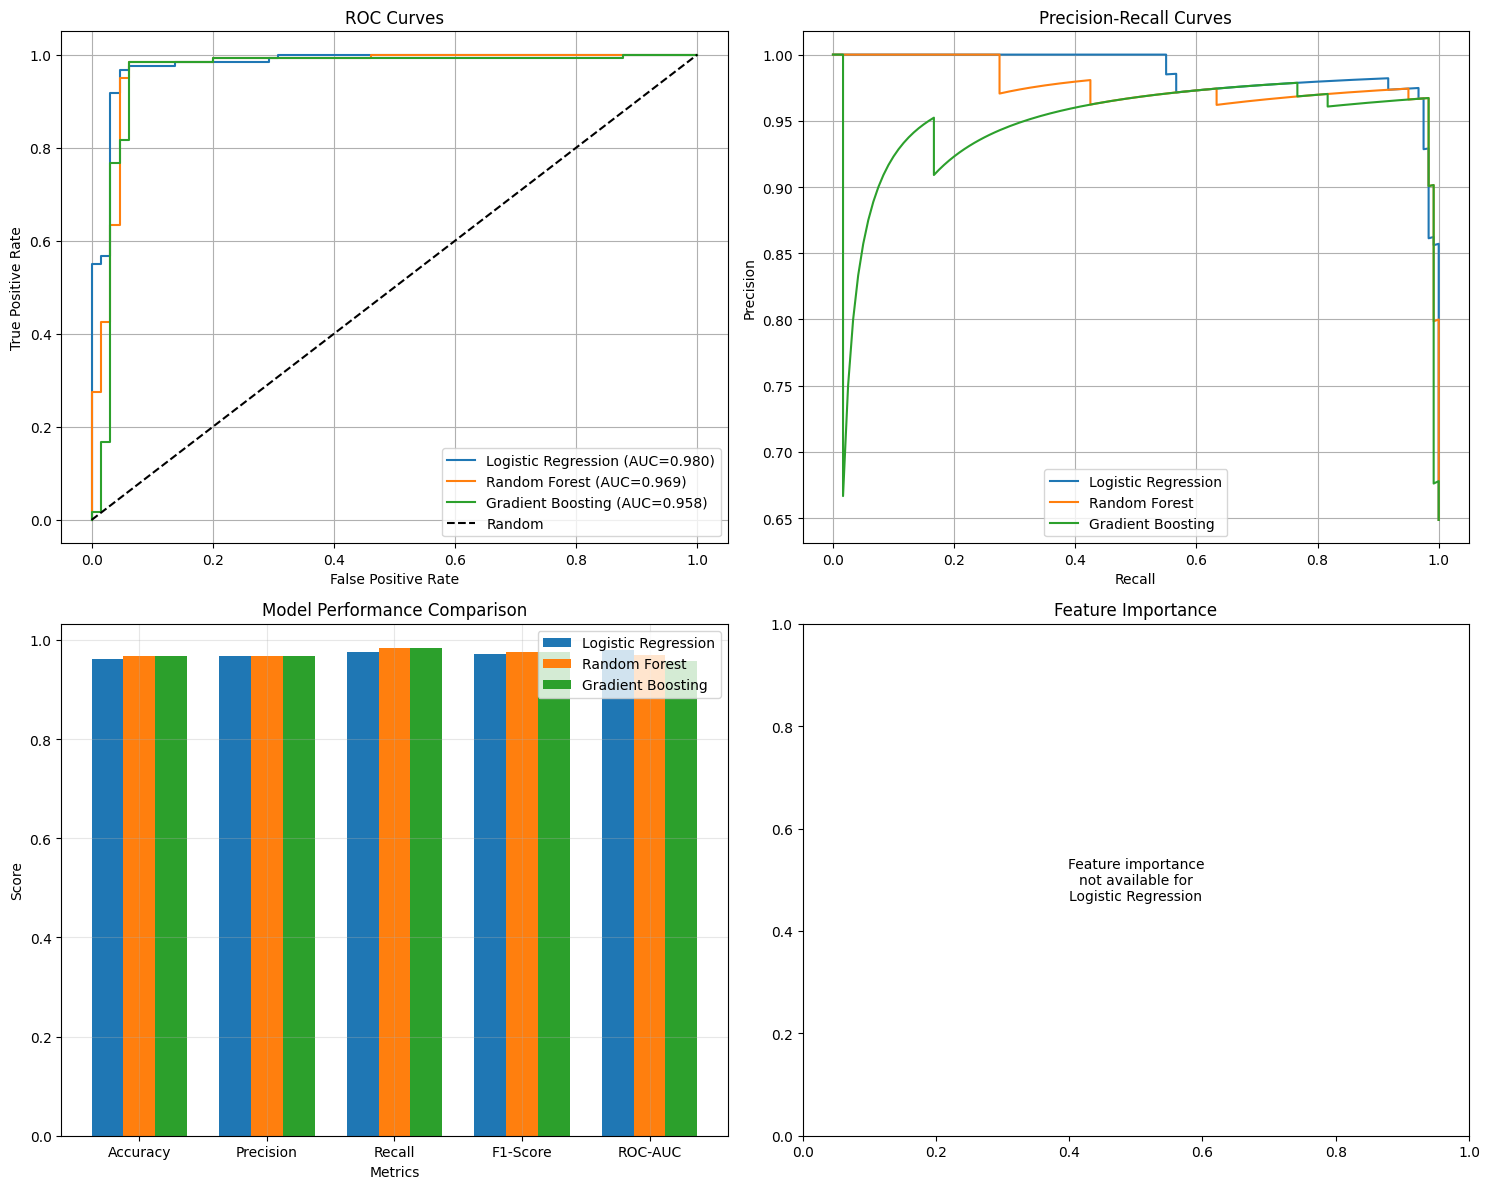


Visualizations created!


In [8]:
# Model Comparison and Visualization
print("=" * 60)
print("STEP 6: Model Comparison")
print("=" * 60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [r['accuracy'] for r in results.values()],
    'Precision': [r['precision'] for r in results.values()],
    'Recall': [r['recall'] for r in results.values()],
    'F1-Score': [r['f1'] for r in results.values()],
    'ROC-AUC': [r['roc_auc'] for r in results.values()],
    'CV ROC-AUC Mean': [r['cv_mean'] for r in results.values()],
    'CV ROC-AUC Std': [r['cv_std'] for r in results.values()]
})

print("\nModel Comparison:")
print(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"{'='*60}")
print(f"ROC-AUC: {results[best_model_name]['roc_auc']:.4f}")
print(f"Precision: {results[best_model_name]['precision']:.4f}")
print(f"Recall: {results[best_model_name]['recall']:.4f}")
print(f"F1-Score: {results[best_model_name]['f1']:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curves
ax1 = axes[0, 0]
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    ax1.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves')
ax1.legend()
ax1.grid(True)

# 2. Precision-Recall Curves
ax2 = axes[0, 1]
for name, result in results.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    ax2.plot(recall_curve, precision_curve, label=name)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves')
ax2.legend()
ax2.grid(True)

# 3. Metric Comparison Bar Chart
ax3 = axes[1, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25
for i, (name, result) in enumerate(results.items()):
    values = [
        result['accuracy'],
        result['precision'],
        result['recall'],
        result['f1'],
        result['roc_auc']
    ]
    ax3.bar(x + i*width, values, width, label=name)
ax3.set_xlabel('Metrics')
ax3.set_ylabel('Score')
ax3.set_title('Model Performance Comparison')
ax3.set_xticks(x + width)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature Importance (for best tree-based model)
ax4 = axes[1, 1]
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_model = results[best_model_name]['model']
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': valid_features,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(20)
        
        ax4.barh(range(len(feature_importance)), feature_importance['importance'])
        ax4.set_yticks(range(len(feature_importance)))
        ax4.set_yticklabels(feature_importance['feature'])
        ax4.set_xlabel('Importance')
        ax4.set_title(f'Top 20 Feature Importance - {best_model_name}')
        ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, 'Feature importance\nnot available for\nLogistic Regression', 
            ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Feature Importance')

plt.tight_layout()
plt.show()

print("\nVisualizations created!")


In [9]:
# Feature Importance Analysis
print("=" * 60)
print("STEP 7: Feature Importance Analysis")
print("=" * 60)

# Get feature importance from tree-based models
for name in ['Random Forest', 'Gradient Boosting']:
    if name in results and hasattr(results[name]['model'], 'feature_importances_'):
        model = results[name]['model']
        importance_df = pd.DataFrame({
            'feature': valid_features,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n{name} - Top 20 Most Important Features:")
        print(importance_df.head(20).to_string(index=False))
        
        # Save to variable for later use
        if name == 'Random Forest':
            rf_importance = importance_df
        else:
            gb_importance = importance_df


STEP 7: Feature Importance Analysis

Random Forest - Top 20 Most Important Features:
                 feature  importance
     in_acquisition_data    0.439396
   has_acquisition_price    0.069758
           relationships    0.055387
 age_last_milestone_year    0.045859
        avg_participants    0.027216
       log_funding_total    0.025343
age_first_milestone_year    0.025073
              milestones    0.023903
       funding_per_round    0.020551
funding_per_relationship    0.020460
       funding_total_usd    0.020175
       company_age_years    0.018405
   days_to_first_funding    0.017325
   age_last_funding_year    0.017144
               longitude    0.016939
   funding_per_milestone    0.016471
   log_funding_per_round    0.016162
  age_first_funding_year    0.016146
                latitude    0.015250
       max_funding_round    0.011520

Gradient Boosting - Top 20 Most Important Features:
                 feature  importance
     in_acquisition_data    0.849331
           

In [11]:
# Final Model Selection and Predictions
print("=" * 60)
print("STEP 8: Final Model and Predictions")
print("=" * 60)

# Ensure best_model_name is defined (in case previous cell wasn't run)
if 'best_model_name' not in locals() and 'best_model_name' not in globals():
    # Find best model by ROC-AUC
    if 'results' in locals() or 'results' in globals():
        best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
        print(f"Determined best model: {best_model_name} (ROC-AUC: {results[best_model_name]['roc_auc']:.4f})")
    else:
        raise ValueError("'results' dictionary not found. Please run the model training cells first.")

# Select best model
best_model = results[best_model_name]['model']
best_scaler = scaler if best_model_name == 'Logistic Regression' else None

print(f"Selected Model: {best_model_name}")
print(f"Model Parameters:")
if hasattr(best_model, 'get_params'):
    params = best_model.get_params()
    for key, value in list(params.items())[:10]:  # Show first 10 params
        print(f"  {key}: {value}")

# Make predictions on full dataset
try:
    if best_model_name == 'Logistic Regression':
        X_full_scaled = scaler.transform(X)
        predictions = best_model.predict(X_full_scaled)
        prediction_proba = best_model.predict_proba(X_full_scaled)[:, 1]
    else:
        predictions = best_model.predict(X)
        prediction_proba = best_model.predict_proba(X)[:, 1]
    
    # Ensure predictions match data length
    if len(predictions) != len(merged_data):
        print(f"Warning: Predictions length ({len(predictions)}) doesn't match data length ({len(merged_data)})")
        print("This might happen if merged_data was modified after feature preparation.")
        # Align predictions with merged_data using index
        pred_series = pd.Series(predictions, index=X.index)
        proba_series = pd.Series(prediction_proba, index=X.index)
        merged_data['predicted_success'] = pred_series.reindex(merged_data.index, fill_value=0)
        merged_data['success_probability'] = proba_series.reindex(merged_data.index, fill_value=0.0)
    else:
        # Add predictions to original data
        merged_data['predicted_success'] = predictions
        merged_data['success_probability'] = prediction_proba
except Exception as e:
    print(f"Error making predictions: {e}")
    print(f"X shape: {X.shape}, merged_data shape: {merged_data.shape}")
    raise

print(f"\nPredictions Summary:")
print(f"  Predicted Success (1): {predictions.sum()} ({predictions.sum()/len(predictions)*100:.2f}%)")
print(f"  Predicted Failure (0): {(predictions==0).sum()} ({(predictions==0).sum()/len(predictions)*100:.2f}%)")
print(f"\n  Average Success Probability: {prediction_proba.mean():.4f}")
print(f"  Median Success Probability: {np.median(prediction_proba):.4f}")

# Show companies with highest success probability
print(f"\nTop 10 Companies by Success Probability:")
try:
    # Select available columns
    display_cols = ['name', 'status', 'success_probability']
    optional_cols = ['funding_total_usd', 'category_code']
    for col in optional_cols:
        if col in merged_data.columns:
            display_cols.append(col)
    
    top_predictions = merged_data.nlargest(10, 'success_probability')[display_cols]
    print(top_predictions.to_string(index=False))
except Exception as e:
    print(f"Could not display top predictions: {e}")
    if 'success_probability' in merged_data.columns:
        print(f"\nTop 5 success probabilities:")
        print(merged_data.nlargest(5, 'success_probability')['success_probability'])


STEP 8: Final Model and Predictions
Selected Model: Logistic Regression
Model Parameters:
  C: 1.0
  class_weight: balanced
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: deprecated
  n_jobs: None
  penalty: l2

Predictions Summary:
  Predicted Success (1): 585 (63.38%)
  Predicted Failure (0): 338 (36.62%)

  Average Success Probability: 0.6345
  Median Success Probability: 0.9584

Top 10 Companies by Success Probability:
           name   status  success_probability  funding_total_usd
        Jumptap acquired             0.999949          121500000
           Digg acquired             0.999939           45000000
          AdMob acquired             0.999898           46800000
      SimpleGeo acquired             0.999897            9807367
         Tumblr acquired             0.999850          125250000
         Amobee acquired             0.999811           72000000
        Mashery acquired             0.999771           3

In [12]:
# Model Summary and Insights
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print(f"\nDataset Information:")
print(f"  Total Companies: {len(merged_data)}")
print(f"  Features Used: {len(valid_features)}")
print(f"  Data Sources Integrated: ", end="")
sources = ["startup data.csv"]
if acq_df is not None:
    sources.append("acq.csv")
if vc_df is not None:
    sources.append("investments_VC.csv")
print(", ".join(sources))

print(f"\nTarget Variable Distribution:")
print(f"  Success (Acquired): {y.sum()} ({y.sum()/len(y)*100:.2f}%)")
print(f"  Failure (Operating/Closed): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.2f}%)")

# Ensure best_model_name is available
if 'best_model_name' not in locals() and 'best_model_name' not in globals():
    if 'results' in locals() or 'results' in globals():
        best_model_name = max(results.keys(), key=lambda k: results[k]['roc_auc'])
    else:
        best_model_name = "Unknown"

if 'results' in locals() or 'results' in globals():
    if best_model_name in results:
        print(f"\nBest Model Performance ({best_model_name}):")
        print(f"  Accuracy:  {results[best_model_name]['accuracy']:.4f}")
        print(f"  Precision: {results[best_model_name]['precision']:.4f}")
        print(f"  Recall:    {results[best_model_name]['recall']:.4f}")
        print(f"  F1-Score:  {results[best_model_name]['f1']:.4f}")
        print(f"  ROC-AUC:   {results[best_model_name]['roc_auc']:.4f}")
    else:
        print(f"\nWarning: Best model '{best_model_name}' not found in results.")
        print("Available models:", list(results.keys()) if 'results' in locals() or 'results' in globals() else "N/A")
else:
    print("\nWarning: Results dictionary not available.")

print(f"\nModel is ready for predictions!")
print(f"Use merged_data['predicted_success'] and merged_data['success_probability'] for predictions.")


FINAL SUMMARY

Dataset Information:
  Total Companies: 923
  Features Used: 48
  Data Sources Integrated: startup data.csv, acq.csv

Target Variable Distribution:
  Success (Acquired): 597 (64.68%)
  Failure (Operating/Closed): 326 (35.32%)

Best Model Performance (Logistic Regression):
  Accuracy:  0.9622
  Precision: 0.9669
  Recall:    0.9750
  F1-Score:  0.9710
  ROC-AUC:   0.9800

Model is ready for predictions!
Use merged_data['predicted_success'] and merged_data['success_probability'] for predictions.
